In [1]:
import xarray as xr
import rioxarray as rxr
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from pyeto import fao

In [169]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary_4326 = ucrb_boundary.copy()
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)
hcdn_boundaries=hcdn_boundaries.to_crs(4326)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


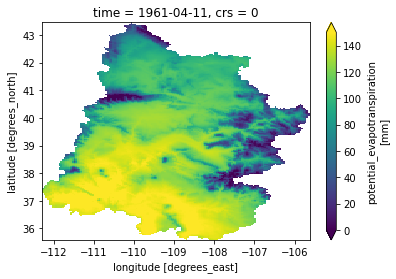

In [170]:
terraclimate_pet = xr.open_dataset('../data/etdata/TerraClimate19812010_pet.nc')
# resample to daily data
terraclimate_pet_daily = terraclimate_pet.resample(time='1D').interpolate('cubic')
# convert to a raster and change crs to match the UCRB boundary
terraclimate_pet_daily = terraclimate_pet_daily.rio.write_crs(4326)
terraclimate_pet_daily.rio.clip(ucrb_boundary_4326.geometry).isel(time=100).pet.plot(vmin=0, vmax=150)

In [180]:
for gage in hcdn_boundaries.index:
    tmp = hcdn_boundaries[hcdn_boundaries.gage == '09112500']
    pet_trc = terraclimate_pet_daily.rio.clip(tmp.geometry)

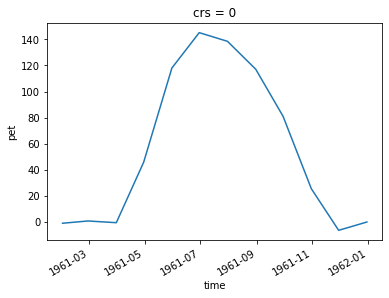

In [192]:
pet_trc.pet.mean(dim=['lon','lat']).resample(time='1M').mean().plot()

In [4]:
pet_ds = rxr.open_rasterio('../data/etdata/pevap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
et_ds = rxr.open_rasterio('../data/etdata/evap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
et_ds=et_ds.rio.write_crs(lcc_proj)
pet_ds = pet_ds.rio.write_crs(lcc_proj)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), t

In [5]:
pet_ds_clipped_ucrb = pet_ds.rio.clip(ucrb_boundary.geometry)
pet_ds_masked_ucrb=pet_ds_clipped_ucrb.where(pet_ds_clipped_ucrb['pevap']!=9.96921e+36)

# convert to mm equivalent
pet_ds_masked_ucrb['pevap'] = pet_ds_masked_ucrb['pevap']*30
pet_ds_masked_ucrb['pevap'].attrs['units']='mm'

# dx = 32462.98850575/32.46298850575
# lon = np.arange(pet_ds_masked_ucrb.x.min(), pet_ds_masked_ucrb.x.max(),dx)
# lat = np.arange(pet_ds_masked_ucrb.y.min(), pet_ds_masked_ucrb.y.max(),dx)
# pet_ds_masked_ucrb=pet_ds_masked_ucrb.interp(x=lon, y=lat, method='linear')
# PET for UCRB as a whole
pet_ds_masked_ucrb['WY'] = pet_ds_masked_ucrb.time.dt.year.where(pet_ds_masked_ucrb.time.dt.month<10,pet_ds_masked_ucrb.time.dt.year+1)
pet_wy_ds_mean_ucrb = pet_ds_masked_ucrb.where(~pet_ds_masked_ucrb['WY'].isin([1979,2023, 2016])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds_ucrb = ((pet_wy_ds_mean_ucrb-pet_wy_ds_mean_ucrb.mean(dim='WY'))/pet_wy_ds_mean_ucrb.std(dim='WY'))['pevap']

In [6]:
et_ds_clipped_ucrb = et_ds.rio.clip(ucrb_boundary.geometry)
et_ds_masked_ucrb=et_ds_clipped_ucrb.where(et_ds_clipped_ucrb['evap']!=9.96921e+36)

# convert to mm equivalent
et_ds_masked_ucrb['evap'] = et_ds_masked_ucrb['evap']*1000
et_ds_masked_ucrb['evap'].attrs['units']='mm'

# dx = 32462.98850575/32.46298850575
# lon = np.arange(et_ds_masked_ucrb.x.min(), et_ds_masked_ucrb.x.max(),dx)
# lat = np.arange(et_ds_masked_ucrb.y.min(), et_ds_masked_ucrb.y.max(),dx)
# et_ds_masked_ucrb=et_ds_masked_ucrb.interp(x=lon, y=lat, method='linear')
# et for UCRB as a whole
et_ds_masked_ucrb['WY'] = et_ds_masked_ucrb.time.dt.year.where(et_ds_masked_ucrb.time.dt.month<10,et_ds_masked_ucrb.time.dt.year+1)
# et_wy_ds_mean_ucrb = et_ds_masked_ucrb.where(~et_ds_masked_ucrb['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim=['x','y'])
# norm_et_ds_ucrb = ((et_wy_ds_mean_ucrb-et_wy_ds_mean_ucrb.mean(dim='WY'))/et_wy_ds_mean_ucrb.std(dim='WY'))['evap']

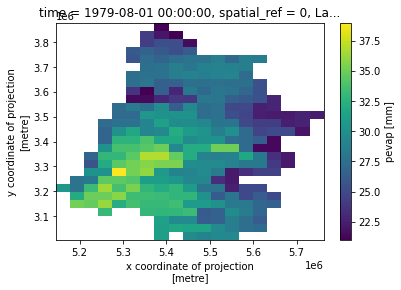

In [7]:
# import resampling
from rasterio.enums import Resampling
# pet_ds_clipped_ucrb_rpj = pet_ds_masked_ucrb.rio.reproject(dst_crs=32613, resampling=Resampling.nearest)
# pet_ds_clipped_ucrb_rpj = pet_ds_clipped_ucrb_rpj.where(pet_ds_clipped_ucrb_rpj < 1000)
pet_ds_masked_ucrb.pevap.isel(time=7).plot()

In [8]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries=hcdn_boundaries.to_crs(lcc_proj)

### Pull in WRF data to estimate

In [91]:
df = pd.DataFrame(columns=['value', 'year', 'month', 'variable'])
for year in range(1987,2021):
    print(f'Processing year {year}...')
    example_ds = xr.open_mfdataset(f'/storage/dlhogan/sos/data/WRF/WY{year}/*.nc')
    # resample to daily mean
    ppt = example_ds.HR_PRCP.resample(XTIME='1M').sum().mean(dim=['south_north', 'west_east'])
    # get the spatial average
    example_ds = example_ds.mean(dim=['south_north', 'west_east']).resample(XTIME='1M').mean()

    ### Calculate necessary variables for PET calculation
    wm2_to_mj2day = 0.0864
    # calculate net radiation
    net_rad = fao.net_rad(ni_sw_rad = example_ds['SWDOWN']*wm2_to_mj2day,
                no_lw_rad = example_ds['GLW']*wm2_to_mj2day,)
    # get average daily 2m temperature
    t = example_ds['T2'].compute()
    if year == 1987:
        t_pre=280
    else:
        t_pre = t.values[0]

    # get the arithmetic mean of U10 and V10 daily wind speed
    u10 = example_ds['U10']
    v10 = example_ds['V10']
    ws = np.sqrt(u10**2 + v10**2)
    # calculate the saturated vapor pressure
    es = 6.11 * np.exp((2.5e6/461.5) * (1/273.15 - 1/(t.values))) # kilopascal
    # calculate the actual vapor pressure
    ea = (example_ds['Q2'] * example_ds['PSFC'] / (0.622 + 0.378 * example_ds['Q2'])).compute()/1000 # kiloPascal
    # calculate the slope of the saturation vapor pressure curve
    delta = 4098 * (0.6108 * np.exp(17.27 * (t.values-273.15) / (t.compute().values-35.86))) / (t.values-35.86)**2 
    # calculate the psychrometric constant
    psy = fao.psy_const(example_ds['PSFC']/1000).compute()
    # calculate the mean soil flux estiamtion
    pre_t = np.roll(t.values,1)
    pre_t[0] = t_pre
    sh = fao.monthly_soil_heat_flux2(pre_t-273.15,t.values-273.15)
    # calculate the PET
    pet = fao.fao56_penman_monteith(net_rad.values,
                            t.values,
                            ws.values,
                            es,
                            ea.values,
                            delta,
                            psy.values,
                            shf=sh)  
    # add ppt to df with measuuremnet = ppt and month going from 10,11,12,1,2,3,4,5,6,7,8,9
    df = pd.concat([df,
                    pd.DataFrame({'value':pet,'variable':'pet','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year}),
                    pd.DataFrame({'value':ppt,'variable':'ppt','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year})],ignore_index=True)

Processing year 1987...
Processing year 1988...
Processing year 1989...
Processing year 1990...
Processing year 1991...
Processing year 1992...
Processing year 1993...
Processing year 1994...
Processing year 1995...
Processing year 1996...
Processing year 1997...
Processing year 1998...
Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...
Processing year 2021...


OSError: no files to open

In [160]:
df.to_csv('../data/etdata/east_river_pet_wrf.csv')
# df = pd.read_csv('../data/etdata/east_river_pet_wrf.csv', index_col=0)

### Same plot but for spring PET and ET

(50.0, 90.0)

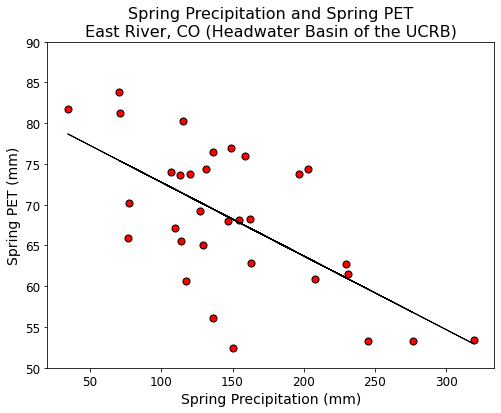

In [93]:
fig, ax = plt.subplots(figsize=(8,6))
# create the pivot table for spring conditions
spring_totals = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='sum').loc[1989:]
# from the pivot table plot spring precipitation against spring pet
ax.scatter(spring_totals['ppt'],spring_totals['pet'],color='red',s=50, ec='k')
# add a best fit line with r2 in the legend
m, b = np.polyfit(spring_totals['ppt'],spring_totals['pet'], 1)
ax.plot(spring_totals['ppt'], m*spring_totals['ppt'] + b, '-', color='k', linewidth=1)
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)',fontsize=14)
ax.set_ylabel('Spring PET (mm)',fontsize=14)
ax.set_title('Spring Precipitation and Spring PET\nEast River, CO (Headwater Basin of the UCRB)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(50,90)

In [157]:
mask = df.value < df2.value*1000
# replace values in mask with df2 pet vlaue
df['value']= np.where(mask, df2.value*1000, df.value)

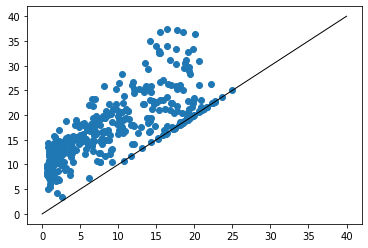

In [159]:
plt.scatter(df2[(df2['variable']=='pet')].value*1000, df[df['variable']=='pet'].value)
# plot 1:1 line
plt.plot([0, 40], [0, 40], color='black', linestyle='-', linewidth=1)

In [128]:
df2.to_csv('../data/etdata/east_river_et_wrf.csv')